In [1]:
import warnings
## No annoying warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import simsurvey.cadence as simul

import simsurvey_tools as sst

In [3]:
# Load 
fields = sst.load_ztf_fields()
plan = simul.SurveyPlan(fields=fields, load_opsim='/home/ufeindt/data/ZTF/long.db', 
                        band_dict={'1': 'desg', '2': 'desr'})

band    skynoise   field       RA           time        Dec   
---- ------------- ----- ------------- ------------- ---------
desr 796.214341107   620        107.75 57467.1255168  24.83077
desr 796.214341107   619        100.25 57467.1261806  24.83077
desr 796.214341107   667     104.65217 57467.1266981  31.75385
desr 796.214341107   618 92.7499999997 57467.1272231  24.83077
desr 796.214341107   617 85.2500000003 57467.1277515  24.83077
desr 796.214341107   616 77.7500000003 57467.1282467  24.83077
desr 796.214341107   616 77.7500000003 57467.1287097  24.83077
desr 796.214341107   664 81.1739100001 57467.1292454  31.75385
desr 796.214341107   663 73.3478299998 57467.1297404  31.75385
desr 796.214341107   709      80.42857 57467.1302849  38.67692
 ...           ...   ...           ...           ...       ...
desg 796.214341107   438     249.58824  57496.501764  -2.86154
desg 796.214341107   438     249.58824  57496.502227  -2.86154
desg 796.214341107   343         297.8 57496.5030147 -1

In [4]:
plan.cadence

band,skynoise,field,RA,time,Dec
str4,float64,int64,float64,float64,float64
desr,796.214341107,620,107.75,57467.1255168,24.83077
desr,796.214341107,619,100.25,57467.1261806,24.83077
desr,796.214341107,667,104.65217,57467.1266981,31.75385
desr,796.214341107,618,92.7499999997,57467.1272231,24.83077
desr,796.214341107,617,85.2500000003,57467.1277515,24.83077
desr,796.214341107,616,77.7500000003,57467.1282467,24.83077
desr,796.214341107,616,77.7500000003,57467.1287097,24.83077
desr,796.214341107,664,81.1739100001,57467.1292454,31.75385
desr,796.214341107,663,73.3478299998,57467.1297404,31.75385


In [7]:
# Follow the same scheme as in the other examples to 
instprop = {"desg":{"gain":1.,"zp":30,"zpsys":'ab'},
            "desr":{"gain":1.,"zp":30,"zpsys":'ab'},
            "desi":{"gain":1.,"zp":30,"zpsys":'ab'}}

mjd_range = (plan.cadence['time'].min(), plan.cadence['time'].max())

tr = simul.get_sn_generator([0.,0.2], ratekind="basic", 
                            dec_range=[-40,90],
                            mjd_range=[mjd_range[0] - 60, mjd_range[-1] + 25])

survey = simul.SimulSurvey(generator=tr, plan=plan, instprop=instprop)
    
lcs = survey.get_lightcurves(progress_bar=True, notebook=True)

Determining field IDs for all objects

Generating lightcurves



:0: FutureWarning: IPython widgets are experimental and may change in the future.


(array([  4.47500000e+03,   2.14100000e+03,   2.18300000e+03,
          1.00900000e+03,   8.80000000e+01,   5.60000000e+01,
          4.80000000e+01,   1.20000000e+01,   0.00000000e+00,
          1.00000000e+00]),
 array([  1. ,   8.7,  16.4,  24.1,  31.8,  39.5,  47.2,  54.9,  62.6,
         70.3,  78. ]),
 <a list of 10 Patch objects>)

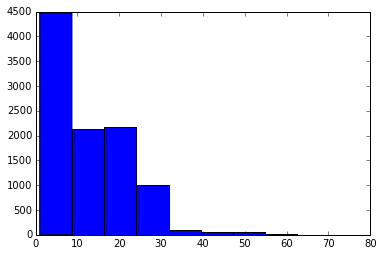

In [12]:
plt.hist([len(lc) for lc in lcs.lcs])